In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sps

from phaseunwrapping import upsampling_matrix, wrap_function, build_1d_first_order_grad, build_2d_first_order_grad, banded_cholesky_factor

# Toy problem

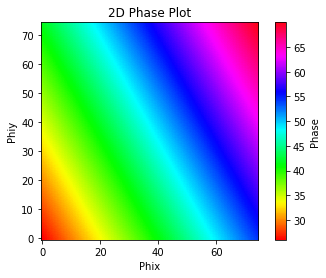

In [4]:
# create phase date for x and y direction
M = 75
N = 75
phix = np.linspace(0, 9*np.pi, M) + (3*np.pi) + 3
phiy = np.linspace(0, 5*np.pi, N) + (4*np.pi) + 1
X, Y = np.meshgrid(phix, phiy)
phi = X + Y

# Create the phase plot (source Chat GPT for the below code)
plt.imshow(phi, cmap='hsv', origin='lower')
plt.colorbar(label='Phase')
plt.xlabel('Phix')
plt.ylabel('Phiy')
plt.title('2D Phase Plot')
plt.show()

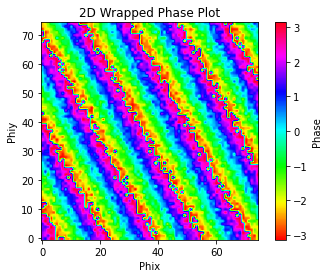

In [5]:
noise_sigma = 0.4
psi = wrap_function(phi + noise_sigma*np.random.normal(size=phi.shape)  )
plt.imshow(psi, cmap='hsv', origin='lower')
plt.colorbar(label='Phase')
plt.xlabel('Phix')
plt.ylabel('Phiy')
plt.title('2D Wrapped Phase Plot')
plt.show()


# Solve

In [18]:
def tikhonov_gradient_2d(psi, reg_lambda=1.0, weights=None):
    """
    """
    M, N = psi.shape

    # Get flattened version of psi
    psi_flatten = psi.flatten()

    # Gradient ops
    Fx, Fy = build_2d_first_order_grad(M, N, boundary="none")

    if weights is None:
        weights = np.ones(Fx.shape[0])
    else:
        assert len(weights) == len(psi), "psi and weight vector must have same length!"
    weights = weights.flatten()

    P = upsampling_matrix(len(psi_flatten) - 1, sparse=True)

    phi1 = np.zeros(len(psi_flatten))
    phi1[0] = psi_flatten[0]

    Dweights = sps.diags(weights)

    # rhs vector
    rhs = P.T @ Fx.T @ Dweights @ ( wrap_function(Fx @ psi_flatten) - (Fx @ phi1) ) + P.T @ Fy.T @ Dweights @ ( wrap_function(Fy @ psi_flatten) - (Fy @ phi1) )

    # Build regularization term
    R1, R2 = build_2d_first_order_grad(M, N)
    R = sps.vstack([R1, R2])

    # Q matrix
    Q = P.T @ Fx.T @ np.diag(weights) @ Fx @ P  + P.T @ Fy.T @ np.diag(weights) @ Fy @ P 
    Q += reg_lambda*(P.T @ R.T @ R @ P)

    # banded cholesky
    L, superlu = banded_cholesky_factor(Q)

    # Compute mean
    sol = superlu.solve(rhs)

    # Include initial phase value
    reconstructed_phi = np.zeros(len(psi_flatten))
    reconstructed_phi[1:] = sol
    reconstructed_phi[0] = psi_flatten[0]
    reconstructed_phi = reconstructed_phi.reshape((M,N))

    return reconstructed_phi

In [31]:
reconstructed_phi = tikhonov_gradient_2d(psi, reg_lambda=1e1, weights=None)

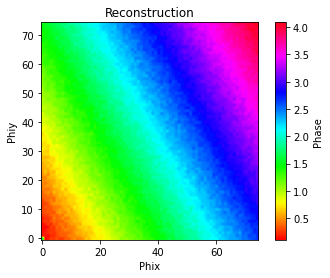

In [32]:
#reconstructed_phi = solve_D2_MLE_2D(psi, Fx, Fy)
#reconstructed_phi = reconstructed_phi.reshape(M,N)
plt.imshow(reconstructed_phi, cmap='hsv', origin='lower')
plt.colorbar(label='Phase')
plt.xlabel('Phix')
plt.ylabel('Phiy')
plt.title('Reconstruction')
plt.show()

# notice the same phase plot basically exceot subtract about 25 from phase